In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import random
from tqdm import tqdm
import numpy as np
from sklearn.datasets.samples_generator import make_blobs
from sklearn.cluster import SpectralClustering, AffinityPropagation

import utils
plt.ion()
plt.show()

elbowAnalysis
silhouetteAnalyis


# Create simulated data

(300, 2)


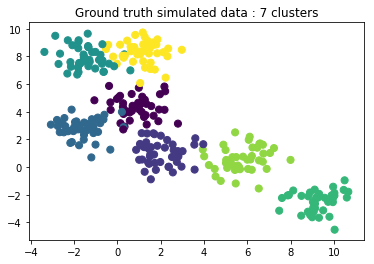

In [2]:
nb_clusters = 7
X, y_true = make_blobs(n_samples=300, centers=nb_clusters,
                       cluster_std=.80, random_state=0)
/print X.shape
plt.title(f'Ground truth simulated data : {nb_clusters} clusters')
plt.scatter(X[:, 0], X[:, 1], s=50, c = y_true);

Let's check some internal cluster quality measures on the ground truth:

In [3]:
utils.internalValidation(X, y_true)

C:\Users\ciort\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


{'_silhouette_score': 0.5297967562708515,
 '_calinski_harabaz_score': 1040.8689458667423,
 '_davies_bouldin_score': 0.627422287101259}

Since the generated data was overlapping on the borders, the silhoutte score is only 0.52

# Spectral clustering

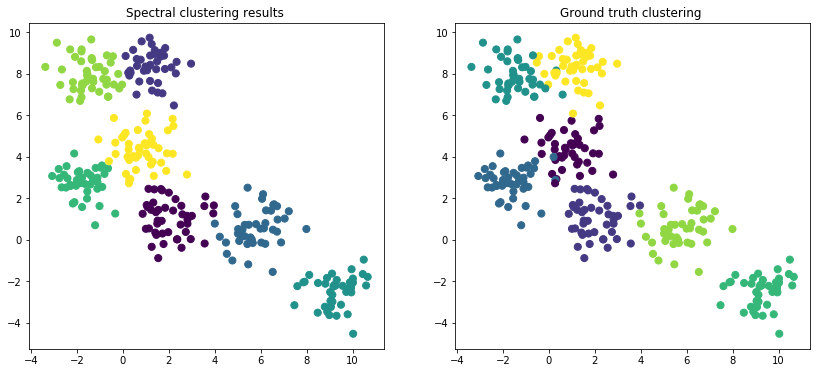

In [4]:
clustering = SpectralClustering(n_clusters=nb_clusters, assign_labels="discretize", random_state=0).fit(X)
y_pred = clustering.labels_
plt.figure(figsize=(14,6))
plt.subplot(121)
plt.title(f'Spectral clustering results ')
plt.scatter(X[:, 0], X[:, 1], s=50, c = y_pred);

plt.subplot(122)
plt.title(f'Ground truth clustering ')
plt.scatter(X[:, 0], X[:, 1], s=50, c = y_true);

## Internal validation

In [5]:
utils.internalValidation(X, y_pred)

C:\Users\ciort\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


{'_silhouette_score': 0.5499510276741219,
 '_calinski_harabaz_score': 1090.6022225853194,
 '_davies_bouldin_score': 0.601991834894388}

## External validation

In [6]:
utils.externalValidation(y_true, y_pred)

C:\Users\ciort\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


{'_rand_index': 0.9178102961787797,
 '_homogeneity_score': 0.9279004285799041,
 '_purity_score': 0.9633333333333334,
 '_adjusted_mutual_info_score': 0.9255052929267704,
 '_fowlkes_mallows_score': 0.929339443464853}

# Affinity propagation

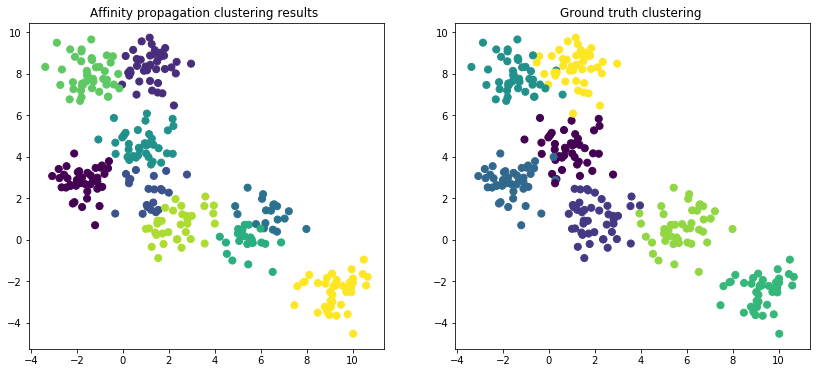

In [7]:
clustering = AffinityPropagation().fit(X)
y_pred = clustering.labels_
plt.figure(figsize=(14,6))
plt.subplot(121)
plt.title(f'Affinity propagation clustering results ')
plt.scatter(X[:, 0], X[:, 1], s=50, c = y_pred);

plt.subplot(122)
plt.title(f'Ground truth clustering ')
plt.scatter(X[:, 0], X[:, 1], s=50, c = y_true);

## Internal validation

In [8]:
utils.internalValidation(X, y_pred)

C:\Users\ciort\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


{'_silhouette_score': 0.48825383430249797,
 '_calinski_harabaz_score': 971.0647349027612,
 '_davies_bouldin_score': 0.7715837846509171}

## External validation

In [9]:
utils.externalValidation(y_true, y_pred)

C:\Users\ciort\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


{'_rand_index': 0.8072648909988033,
 '_homogeneity_score': 0.9061819039569069,
 '_purity_score': 0.94,
 '_adjusted_mutual_info_score': 0.8109976869443003,
 '_fowlkes_mallows_score': 0.8351636317846468}

# Self tuned clustering and optimal number of clusters approximation

The idea behind the self tuning spectral clustering is determine the optimal number of clusters and also the similarity metric σi used in the computation of the affinity matrix.

In [10]:
from scipy.spatial.distance import pdist, squareform
def getAffinityMatrix(coordinates, k = 7):
    """
    Calculate affinity matrix based on input coordinates matrix and the numeber
    of nearest neighbours.
    
    Apply local scaling based on the k nearest neighbour
        References:
    https://papers.nips.cc/paper/2619-self-tuning-spectral-clustering.pdf
    """
    # calculate euclidian distance matrix
    dists = squareform(pdist(coordinates)) 
    
    # for each row, sort the distances ascendingly and take the index of the 
    #k-th position (nearest neighbour)
    knn_distances = np.sort(dists, axis=0)[k]
    knn_distances = knn_distances[np.newaxis].T
    
    # calculate sigma_i * sigma_j
    local_scale = knn_distances.dot(knn_distances.T)

    affinity_matrix = dists * dists
    affinity_matrix = -affinity_matrix / local_scale
    # divide square distance matrix by local scale
    affinity_matrix[np.where(np.isnan(affinity_matrix))] = 0.0
    # apply exponential
    affinity_matrix = np.exp(affinity_matrix)
    np.fill_diagonal(affinity_matrix, 0)
    return affinity_matrix

In [11]:
affinity_matrix = getAffinityMatrix(X, k = 7)

# Eigengap heuristic for finding the optimal number of clusters

This paper A Tutorial on Spectral Clustering - Ulrike von Luxburg proposes an approach based on perturbation theory and spectral graph theory to calculate the optimal number of clusters.  
Eigengap heuristic suggests the number of clusters k is usually given by the value of k that maximizes the eigengap (difference between consecutive eigenvalues). The larger this eigengap is, the closer the eigenvectors of the ideal case and hence the better spectral clustering works.

In [23]:
import scipy
from scipy.sparse import csgraph
# from scipy.sparse.linalg import eigsh
from numpy import linalg as LA
def eigenDecomposition(A, plot = True, topK = 5):
    """
    :param A: Affinity matrix
    :param plot: plots the sorted eigen values for visual inspection
    :return A tuple containing:
    - the optimal number of clusters by eigengap heuristic
    - all eigen values
    - all eigen vectors
    
    This method performs the eigen decomposition on a given affinity matrix,
    following the steps recommended in the paper:
    1. Construct the normalized affinity matrix: L = D−1/2ADˆ −1/2.
    2. Find the eigenvalues and their associated eigen vectors
    3. Identify the maximum gap which corresponds to the number of clusters
    by eigengap heuristic
    
    References:
    https://papers.nips.cc/paper/2619-self-tuning-spectral-clustering.pdf
    http://www.kyb.mpg.de/fileadmin/user_upload/files/publications/attachments/Luxburg07_tutorial_4488%5b0%5d.pdf
    """
    L = csgraph.laplacian(A, normed=True)
    n_components = A.shape[0]
    
    # LM parameter : Eigenvalues with largest magnitude (eigs, eigsh), that is, largest eigenvalues in 
    # the euclidean norm of complex numbers.
#     eigenvalues, eigenvectors = eigsh(L, k=n_components, which="LM", sigma=1.0, maxiter=5000)
    eigenvalues, eigenvectors = LA.eig(L)
    
    if plot:
        plt.title('Largest eigen values of input matrix')
        plt.scatter(np.arange(len(eigenvalues)), eigenvalues)
        plt.grid()
        
    # Identify the optimal number of clusters as the index corresponding
    # to the larger gap between eigen values
    index_largest_gap = np.argsort(np.diff(eigenvalues))[::-1][:topK]
    nb_clusters = index_largest_gap + 1
        
    return nb_clusters, eigenvalues, eigenvectors

Optimal number of clusters [ 59  89   7 104 131]


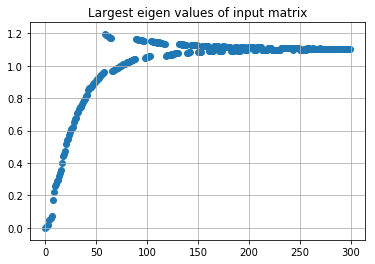

In [24]:
affinity_matrix = getAffinityMatrix(X, k = 10)
k, _,  _ = eigenDecomposition(affinity_matrix)
print(f'Optimal number of clusters {k}')